In [74]:
# import libraries

import pandas as pd
import numpy as np
from sklearn import cluster
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
import matplotlib.pyplot as plt
%matplotlib inline

In [75]:
# import iyer.txt dataset

cols = ['Gene_ID', 'Ground_Truth_Cluster_ID', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12']
df_iyer = pd.read_csv('./Datasets/iyer.txt', sep="	", names=cols, header=None)

# remove outliers
df_iyer = df_iyer[df_iyer.Ground_Truth_Cluster_ID != -1]

c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

Text(0, 0.5, 'SSE')

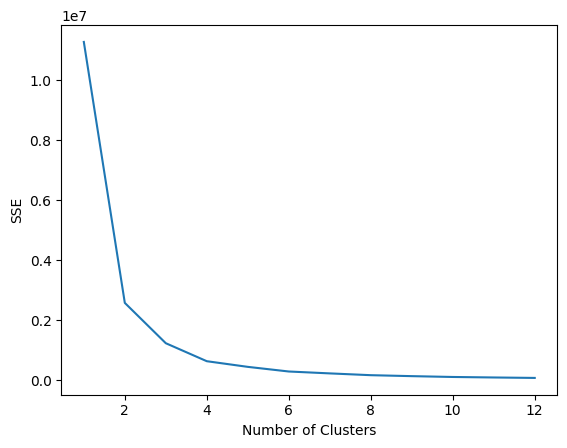

In [76]:
# estimate the number of clusters using a SSE vs. number of clusters graph

numClusters = [1,2,3,4,5,6,7,8,9,10,11,12]
SSE = []
for k in numClusters:
    k_means = cluster.KMeans(n_clusters=k)
    k_means.fit(df_iyer)
    SSE.append(k_means.inertia_)

plt.plot(numClusters, SSE)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

In [77]:
# normalize dataset

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_iyer)

# PCA with n = 3
pca = PCA(n_components=3).fit(scaled_data)
print('Explained Variance Ratio: ', pca.explained_variance_ratio_)
print('Sum of variance by these 3 components: ', pca.explained_variance_ratio_.cumsum()[2])
print('\nSingular Values: ', pca.singular_values_)

df_iyer_3D = pca.transform(scaled_data)

Explained Variance Ratio:  [0.4703368  0.19582588 0.11800056]
Sum of variance by these 3 components:  0.7841632385067087

Singular Values:  [54.39999192 35.10180147 27.2481102 ]


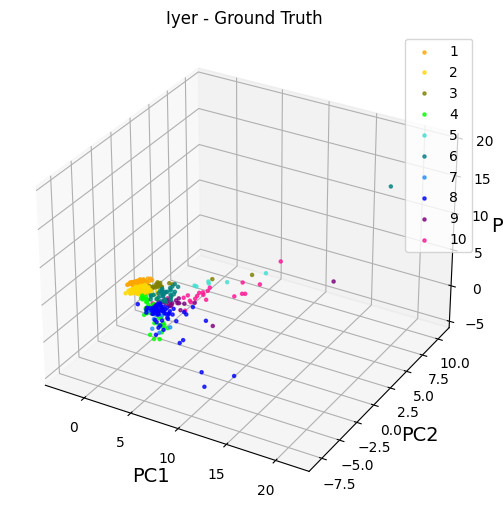

In [78]:
# use PCA to show ground truth label

# set 3 axis
Xax = df_iyer_3D[:,0]
Yax = df_iyer_3D[:,1]
Zax = df_iyer_3D[:,2]

# create figure variables
fig = plt.figure(figsize=(7,5), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')
cdict = {0:'red', 1:'orange', 2:'gold', 3:'olive', 4:'lime', 5:'turquoise', 6:'teal', 7:'dodgerblue', 8:'blue', 9:'purple', 10:'deeppink'}
y = df_iyer.Ground_Truth_Cluster_ID

# draw figure
fig.patch.set_facecolor('white')
for l in np.unique(y):
 i = np.where(y==l)
 ax.scatter(Xax[i], Yax[i], Zax[i], c=cdict[l], s=5, alpha=0.75, label=l)

ax.set_xlabel("PC1", fontsize=14)
ax.set_ylabel("PC2", fontsize=14)
ax.set_zlabel("PC3", fontsize=14)

plt.title('Iyer - Ground Truth')
plt.legend()
plt.show()

c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


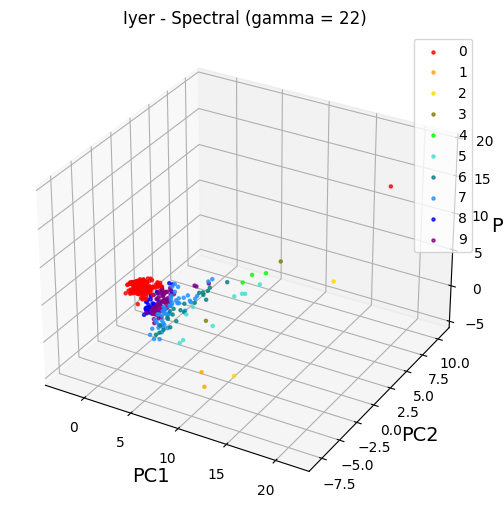

In [79]:
# implement spectral clustering

spectral = cluster.SpectralClustering(n_clusters=10,random_state=1,affinity='rbf',gamma=22)
spectral.fit(df_iyer_3D[:, 0:1:2])   # See what happened for spectral results and confusion matrix below with the parameter as input

# create figure variables
fig = plt.figure(figsize=(7,5), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')
cdict = {0:'red', 1:'orange', 2:'gold', 3:'olive', 4:'lime', 5:'turquoise', 6:'teal', 7:'dodgerblue', 8:'blue', 9:'purple', 10:'deeppink'}
y = spectral.labels_

# draw figure
fig.patch.set_facecolor('white')
for l in np.unique(y):
 i = np.where(y==l)
 ax.scatter(Xax[i], Yax[i], Zax[i], c=cdict[l], s=5, alpha=0.75, label=l)

ax.set_xlabel("PC1", fontsize=14)
ax.set_ylabel("PC2", fontsize=14)
ax.set_zlabel("PC3", fontsize=14)

plt.title('Iyer - Spectral (gamma = 22)')
plt.legend()
plt.show()

In [82]:
# Use external indices for accuracy measurement 

# purity function
def purity_score(truth, predicted):
    contingency_matrix = np.c_[(truth, predicted)]
    # Sum(min(counts per cluster per class)) / total number of data points
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

# set ground truths and predicteds
ground_truth = df_iyer.Ground_Truth_Cluster_ID
predicted = spectral.labels_

# calculate external indices
ari = metrics.adjusted_rand_score(ground_truth, predicted)
purity = purity_score(ground_truth, predicted)
nmi = normalized_mutual_info_score(ground_truth, predicted)

# Print results
print("Iyer - Spectral")
print("Adjusted Rand Index:", ari)
print("Purity:", purity)
print("Normalized Mutual Information:", nmi)

Iyer - Spectral
Adjusted Rand Index: 0.36890801794919287
Purity: 0.005492917028042787
Normalized Mutual Information: 0.41705520580456856
